# Chebyshev Approximation (1D)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from scipy.fftpack import dct, dctn, fft, fft2
from scipy.interpolate import lagrange
#import itertools

In [2]:
# start = timer()
# stop = timer()
# time = stop - start
# print('Runtime = ' + str(time))

## Definitions

For $n \in \mathbb{Z}$, $n \geq 0$, $-1 \leq x \leq 1$, the Chebyshev polynomials (of the first kind), are defined by $$T_n(x) \stackrel{\Delta}{=} \cos \left[n \arccos(x) \right] .$$

From this we immediately find $T_0(x) = 1$, $T_1(x) = x$. The Chebyshev polynomials satisfy a recursive relation:
$$T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x).$$

The roots of $T_n(x)$ are all real, distinct, and contained in the interval $[-1,1]$, given by 
$$ x_k = \cos \left[ \frac{\pi}{n} \left( k + \frac{1}{2} \right) \right] , $$
for $0 \leq k \leq m-1$. 

In [3]:
def chebyshev(n,x):
    
    if n == 0:
        output = 1
    elif n == 1:
        output = x
    else:
        output = 2*x*chebyshev(n-1,x) - chebyshev(n-2,x)
        
    return output
# end of chebyshev

# roots of T_n(x)
def roots(n):
    output = np.zeros(n)
    
    for k in range(n):
        output[k] = np.cos( np.pi * (k + 1/2) / n ) # need to shift by 1
    # end of for loop for initializing roots
    
    return output
# end of roots

# interpolation nodes
def cheb_nodes(n):
    output = np.zeros(n+1)
    
    for k in range(n+1):
        output[k] = np.cos( np.pi * k / n )
    # end of for loop for initializing nodes
    
    return output
# end of cheb_nodes

## Plotting

The Chebyshev polynomials are orthogonal on $[-1,1]$ with weight function 
$$w(x) = \frac{1}{\sqrt{1-x^2}}.$$
For any $n,m \in \mathbb{Z}$, 
$$ \left \langle T_n , T_m \right \rangle \stackrel{\Delta}{=} \int_{-1}^{1} T_n(x) T_m(x) w(x) \, \mathrm{d}x = 
\begin{cases}
    0 , & \qquad n \neq m , \\ 
    \frac{\pi}{2} , & \qquad n = m \neq 0 , \\ 
    \pi , & \qquad n = m = 0 . 
\end{cases}
$$

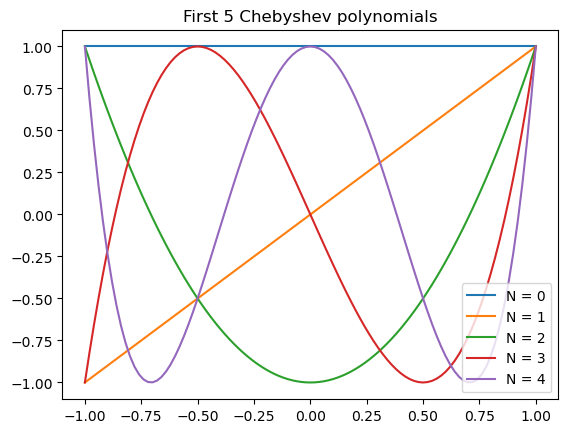

In [4]:
for N in range(5):

    X = np.linspace(-1,1,100+1)
    Y = np.linspace(-1,1,100+1)

    for i in range(len(Y)):
        Y[i] = chebyshev(N,X[i])
    # end of for loop for Y

    plt.plot(X,Y,label = 'N = '+ str(N))

# end of for loop in N
plt.title('First ' + str(N+1) + ' Chebyshev polynomials')
plt.legend()

## Discrete Orthogonality Condition

For $m \geq 1$, let $x_k$ denote the roots of $T_m$, where $0 \leq k \leq m-1$. Then for any $0 \leq i, j \leq m-1$, 
$$ \sum\limits_{k = 1}^m T_i \left( x_k \right) T_j \left( x_k \right) = \begin{cases}
    0 , & \qquad i \neq j , \\ 
    \frac{m}{2} , & \qquad i = j \neq 0 , \\ 
    m , & \qquad i = j = 0 . 
\end{cases} $$

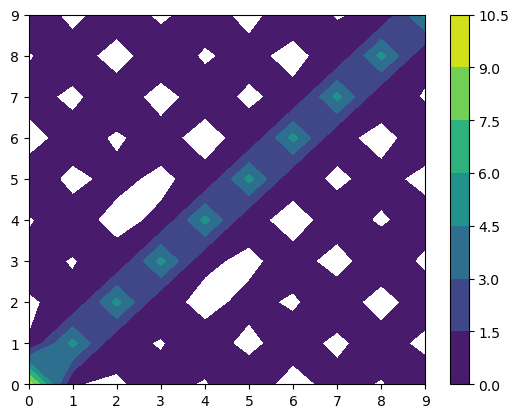

In [5]:
m = 10
A = np.zeros((m,m))
R = roots(m)

for i in range(m):
    for j in range(m):
        
        B = 0 # running sum
        for k in range(m):
            B += chebyshev(i,R[k])*chebyshev(j,R[k])
        # end of for loop for sum in k
        
        A[i,j] = B
    # end of for loop in j
# end of for loop in i

X, Y = np.meshgrid(np.linspace(0,m-1,m),np.linspace(0,m-1,m))
plt.contourf(X,Y,A)
plt.colorbar()

## Approximation

Given $f : [-1,1] \to \mathbb{R}$, the interpolant $p_{f,n}$ of degree $n \in \mathbb{N}$ is given by $$p_{f,n}(x) \stackrel{\Delta}{=} \sum\limits_{k = 0}^n'' \hat{f}^n_k T_k(x),$$ where $$\hat{f}^n_k \stackrel{\Delta}{=} \sum\limits_{j = 0}^n'' f \left( x^n_j \right) \cos \left( \frac{\pi j k}{n} \right),$$ where $\Sigma''$ denotes that the first and last terms in the sum are divided by $2$. The Chebyshev nodes $x^n_j$ are given by $$x^n_j \stackrel{\Delta}{=} \cos \left( \frac{\pi j}{n} \right).$$ Up to scaling, $\hat{f}^n_k$ is the discrete cosine transform of the values of $f$ at the Chebyshev nodes. 

In [6]:
def f(x):
    if x >= 0:
        return x**2
    else:
        return -x**2
# end of f 

direct evaluation of function $f$

In [7]:
# direct evaluation of f
def cheb_approx_1(f,N,x):
    w = np.ones(N+1)
    # manually fix first and last weights
    w[0] = w[0] / 2
    w[N] = w[N] / 2
    
    f_hat = np.zeros(N+1)
    
    for k in range(N+1):
        A = 0 # running sum
        
        for j in range(N+1):
            A += w[j] * f( np.cos(np.pi*j/N) ) * np.cos(np.pi*j*k/N)
        # end of sum over j
        
        f_hat[k] = 2 * A / N
    # end of for loop in k
    
    # manually fix first and last coefficients
    f_hat[0] = f_hat[0] / 2
    f_hat[N] = f_hat[N] / 2
    
    B = 0 # running sum
    for k in range(N+1):
        B += f_hat[k] * chebyshev(k,x)
    # end of sum over k
    
    return B
# end of cheb_approx_1

SciPy discrete cosine transform

In [8]:
def cheb_approx_2(f,N,x):
    f_values = np.zeros(N+1)
    for n in range(len(f_values)):
        f_values[n] = f(cheb_nodes(N)[n])
    # end of for loop to initialize f_values
    f_coeffs = dct(f_values,type=1) / (len(f_values)-1) # normalization
    
    # manually input
    f_coeffs[0] = f_coeffs[0] / 2
    f_coeffs[-1] = f_coeffs[-1] / 2
    
    A = 0 # runing sum
    
    for n in range(len(f_coeffs)):
        A += f_coeffs[n]*chebyshev(n,x)
    # end of for loop in n

    return A
# end of cheb_approx_2

Barycentric formula

In [9]:
def cheb_approx_3(f,N,x):
    tol = 10**(-6)
    X = cheb_nodes(N)
    f_values = np.zeros(N+1)
    for n in range(N+1):
        f_values[n] = f(X[n])
    # end of for loop to initialize f_values
    
    # barycentric weights
    Lambda = np.zeros(N+1)
    for n in range(N+1):
        Lambda[n] = (-1)**n
    # end of for loop to initialize Lambda
    
    # manually input
    Lambda[0] = Lambda[0] / 2
    Lambda[-1] = Lambda[-1] / 2
    
    # tolerance testing
    if np.amin(np.abs(x - X)) < tol:
        # x is too close to a node, so return interpolated value to closest node
        return f_values[np.argmin(np.abs(x - X))]
    else:
        # running sum 
        A = 0 
        B = 0
        
        for n in range(N+1):
            A += Lambda[n] / (x - X[n])
            B += f_values[n] * Lambda[n] / (x - X[n])
        # end of sum in n
        return B / A
# end of cheb_approx_3

Test against each other!

In [10]:
def plot_and_test(f,M,N,mode):
    X = np.linspace(-1,1,M+1)
    Y = np.linspace(-1,1,M+1) # f values for plotting
    Z = np.linspace(-1,1,M+1) # interpolant values for plotting

    for i in range(M+1):
        Y[i] = f(X[i])
    # end of for loop to initialize f values for plotting

    start = timer()
    for i in range(M+1):
        if mode == 1: # direct function evaluation
            Z[i] = cheb_approx_1(f,N,X[i])
        elif mode == 2: # SciPy DCT
            Z[i] = cheb_approx_2(f,N,X[i])
        elif mode == 3: # Barycentric formula
            Z[i] = cheb_approx_3(f,N,X[i])
        else:
            raise Exception('Ooff')
            break 
    # end of for loop to initialize interpolant for plotting
    stop = timer()
    time = stop - start
    print('Runtime = ' + str(time))

    plt.plot(X,Y,label = 'f')
    plt.plot(X,Z,label = 'approx, N = ' + str(N))
    plt.legend()
    plt.figure()

    plt.plot(X,abs(Y-Z))
    plt.title('Error for N = ' + str(N))
    max_error = max(abs(Y-Z))
    plt.figure()
    print('Max error = ' + str(max_error))
# end of plot_and_test

Runtime = 25.3899549
Max error = 0.0007112273508332097
Runtime = 28.4318635
Max error = 0.0007112273508320995
Runtime = 0.009150099999999384
Max error = 0.0007112273508321099


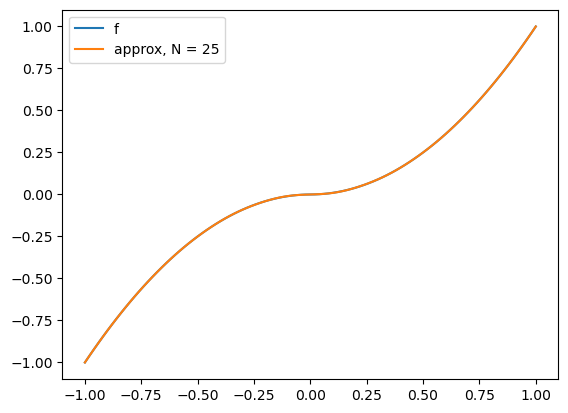

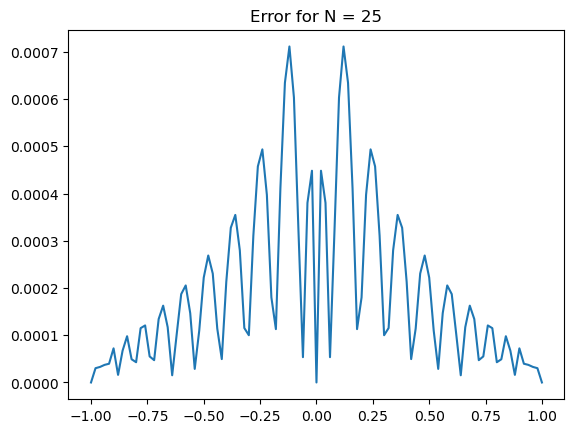

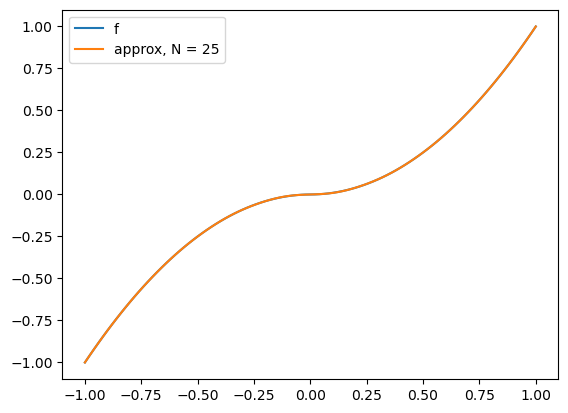

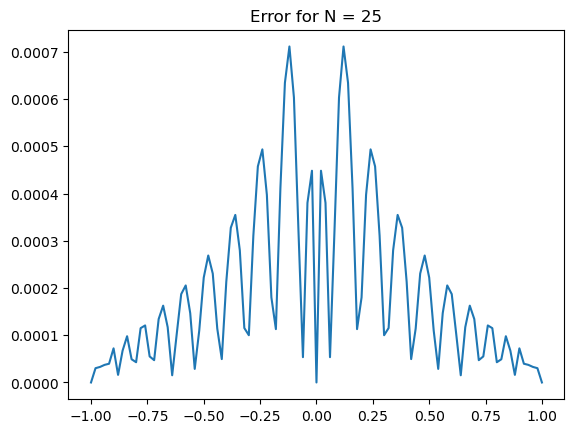

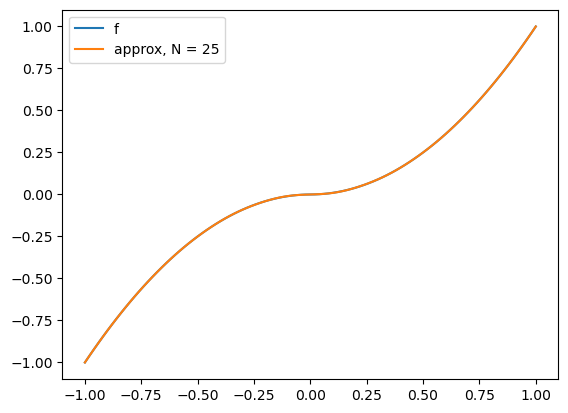

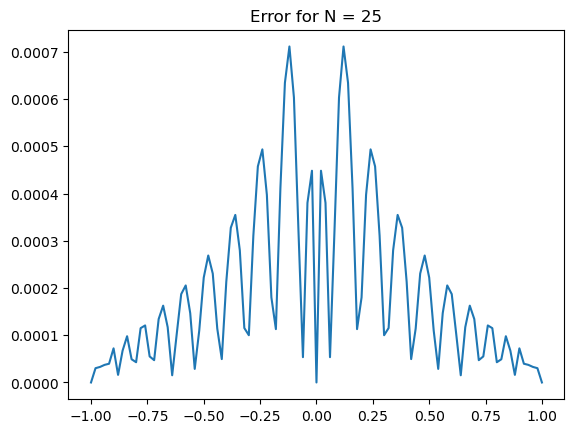

<Figure size 640x480 with 0 Axes>

In [11]:
M = 100
N = 25
for mode in range(1,3+1):
    plot_and_test(f,M,N,mode)

implement cosine transform or FFT 
rate of convergence, test against different levels of smoothness
decay of coefficients

## Error Analysis

Runtime = 0.36093360000000985


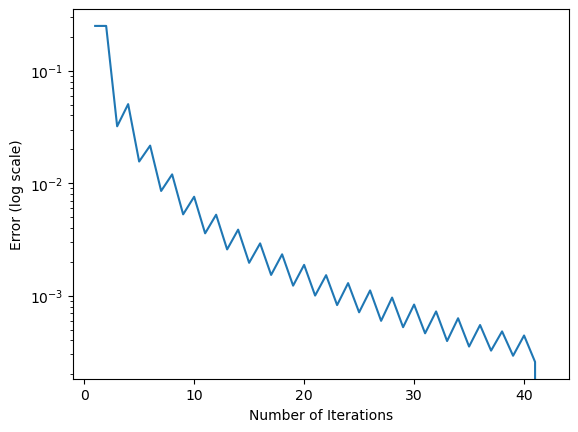

In [12]:
def error_analysis(f,N):
    X = np.linspace(-1,1,100+1)
    Y = np.linspace(-1,1,100+1)
    for i in range(len(Y)):
        Y[i] = f(X[i])
    # end of for loop in i
    error = np.zeros(N+1)
    
    for n in range(1,N+1): # need to start at n = 1
        Z = np.linspace(-1,1,100+1)
        
        for i in range(len(Z)):
            Z[i] = cheb_approx_3(f,n,X[i])
        # end of for loop in i
        
        error[n-1] = np.max(np.abs(Y-Z))
    # end of for loop in n
    
    plt.semilogy()
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error (log scale)')
    plt.plot(np.linspace(1,N+1,N+1),error)
# end of error_analysis


N = 40
start = timer()
error_analysis(f,N+1)
stop = timer()
time = stop - start
print('Runtime = ' + str(time))

testing smoothness

In [13]:
def test_for_smoothness(s,N,M):
    
    # function that is only C^s
    def f_test(s,x):
        if s == 0: # sign function
            if x > 0:
                return 1
            elif x < 0:
                return -1
            else:
                return 0
            # end of if-else statement for sgn(x)
        elif s == 1: # absolute value
            return np.abs(x)
        else:
            if x >= 0:
                return x**s
            else:
                return -x**s
            # end of if-else statement for |x| x^(s-1)
        # end of if-else statement for s
    # end of f_test
    
    # cheb_approx using barycentric formula
    def cheb_approx_4(s,N,x):
        
        tol = 10**(-6)
    
        f_values = np.zeros(N+1)
        for n in range(N+1):
            X = cheb_nodes(N)
            f_values[n] = f_test(s,X[n])
        # end of for loop to initialize f_values

        # barycentric weights
        Lambda = np.zeros(N+1)
        for n in range(N+1):
            Lambda[n] = (-1)**n
        # end of for loop to initialize Lambda

        # manually input
        Lambda[0] = Lambda[0] / 2
        Lambda[-1] = Lambda[-1] / 2

        # tolerance testing
        if np.amin(np.abs(x - X)) < tol:
            # x is too close to a node, so return interpolated value to closest node
            return f_values[np.argmin(np.abs(x - X))]
        else:
            # running sum 
            A = 0 
            B = 0

            for n in range(N+1):
                A += Lambda[n] / (x - X[n])
                B += f_values[n] * Lambda[n] / (x - X[n])
            # end of sum in n
            return B / A
    # end of cheb_approx_4
    
    X = np.linspace(-1,1,M+1)
    error = np.zeros(s+1)
    
    for k in range(len(error)):
        Y = np.linspace(-1,1,M+1)
        Z = np.linspace(-1,1,M+1)
        
        for i in range(len(Y)):
            Y[i] = f_test(k,X[i])
        # end of for loop in i
        
        for i in range(len(Z)):
            Z[i] = cheb_approx_4(k,N,X[i])
        # end of for loop in i
        
        error[k] = np.max(np.abs(Y-Z))
    # end of for loop in n
    
    plt.semilogy()
    plt.xlabel('Order of derivatives')
    plt.ylabel('Error (log scale)')
    plt.stem(np.linspace(0,s,s+1),error)
    plt.title('Degree of interpolant N = ' + str(N))
# end of test_for_smoothness

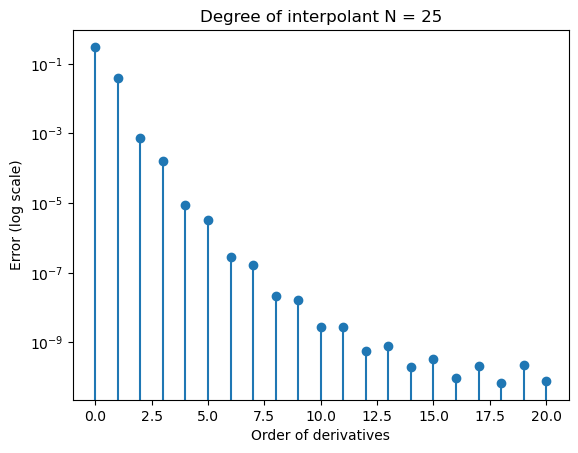

In [14]:
s = 20
N = 25
M = 50
test_for_smoothness(s,N,M)

decay of coefficients

In [15]:
# RePu
def f_test(s,x):
    if x > 0:
        return x**s
    else:
        return 0
# end of f_test

def coeff_decay(s,N):
    f_values = np.zeros(N+1)
    for n in range(len(f_values)):
        f_values[n] = f_test(s,cheb_nodes(N)[n])
    # end of for loop to initialize f_values
    f_coeffs = dct(f_values,type=1) / (len(f_values)-1) # normalization

    # manually input
    f_coeffs[0] = f_coeffs[0] / 2
    f_coeffs[-1] = f_coeffs[-1] / 2
    
    plt.semilogy()
    plt.stem(np.linspace(0,N,N+1),f_coeffs)
    plt.title('s = ' + str(s))
# end of coeff_decay

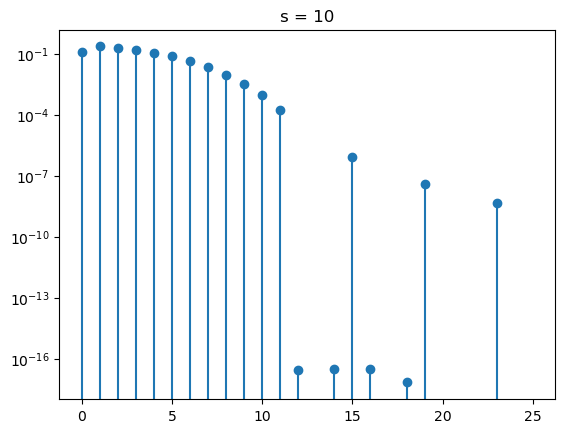

In [16]:
s = 10
N = 25
coeff_decay(s,N)

try taking derivatives
write up series expansion

## Derivatives

First, define the Chebyshev polynomials of the second kind: for $x = \cos(\theta) \in [-1,1]$,  
$$
    U_n(\cos(\theta)) \stackrel{\Delta}{=} \frac{ \sin \left[ (n+1) \theta \right] }{ \sin(\theta) } .
$$
From this we get $U_0(x) \equiv 1$, $U_1(x) = 2x$, and the same recurrence relation as before:
$$
    U_{n}(x) = 2x U_{n-1}(x) - U_{n-2}(x) . 
$$
From this we can write the derivatives of the $T_n$'s as 
$$
    T_n'(x) = n U_{n-1}(x) . 
$$

In [17]:
def chebyshev_2(n,x):
    output = 0
    
    if n == 0:
        output = 1
    elif n == 1:
        output = 2*x
    else:
        output = 2*x*chebyshev_2(n-1,x) - chebyshev_2(n-2,x)
        
    return output
# end of chebyshev_2

In [18]:
# use SciPy DCT for now 
def cheb_approx_derivative(f,N,x):
    f_values = np.zeros(N+1)
    for n in range(len(f_values)):
        f_values[n] = f(cheb_nodes(N)[n])
    # end of for loop to initialize f_values
    f_coeffs = dct(f_values,type=1) / (len(f_values)-1) # normalization
    
    # manually input
    f_coeffs[0] = f_coeffs[0] / 2
    f_coeffs[-1] = f_coeffs[-1] / 2
    
    A = 0 # runing sum for derivative  
    
    for n in range(1,len(f_coeffs)):
        A += f_coeffs[n]*n*chebyshev_2(n-1,x)
    # end of for loop in n

    return A
# end of cheb_approx_2

In [19]:
# input f_prime manually
def test_derivative(f,f_prime,M,N):
    X = np.linspace(-1,1,M+1)
    Y = np.linspace(-1,1,M+1) # f_prime values for plotting
    Z = np.linspace(-1,1,M+1) # derivative of interpolant values for plotting

    for i in range(M+1):
        Y[i] = f_prime(X[i])
    # end of for loop to initialize f_prime values for plotting

    start = timer()
    for i in range(M+1):
        Z[i] = cheb_approx_derivative(f,N,X[i])
    stop = timer()
    time = stop - start
    print('Runtime = ' + str(time))

    plt.plot(X,Y,label = "f'(x)")
    plt.plot(X,Z,label = 'derivative of interpolant, N = ' + str(N))
    plt.legend()
    plt.figure()

    plt.plot(X,abs(Y-Z))
    plt.title('Error for N = ' + str(N))
    max_error = max(abs(Y-Z))
    plt.figure()
    print('Max error = ' + str(max_error))
# end of plot_and_test

In [26]:
def f(x):
    output = 0
    tol = 10**(-6)
    
    if np.abs(x) < tol:
        output = 0
    else:
        output = np.exp( -x**(-2) )
        
    return output
# end of f

def f_prime(x):
    output = 0
    tol = 10**(-6)
    
    if np.abs(x) < tol:
        output = 0
    else:
        output = np.exp( -x**(-2) )*( 2* x**(-3))
        
    return output

Runtime = 0.008495099999976219
Max error = 0.08046683903022323


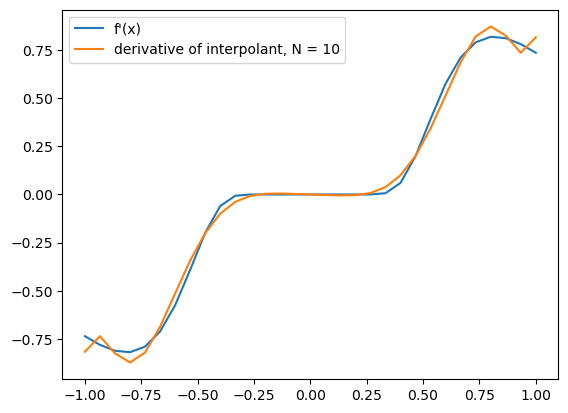

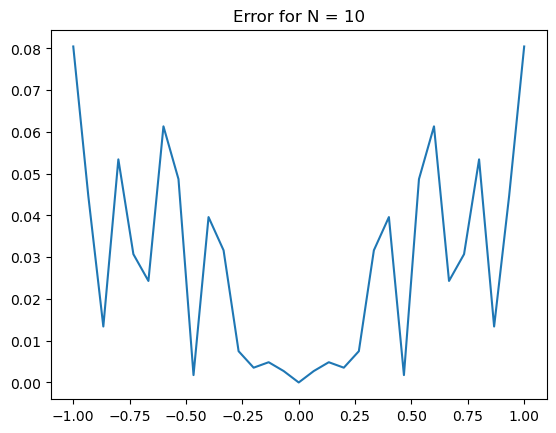

<Figure size 640x480 with 0 Axes>

In [27]:
M = 30
N = 10
test_derivative(f,f_prime,M,N)

Test error analysis for derivatives

Runtime = 5.157681600000018


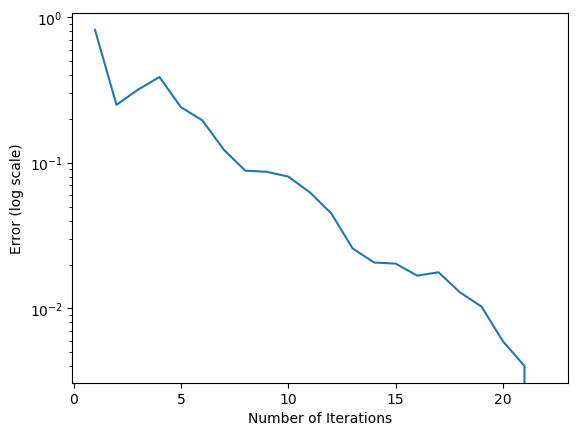

In [28]:
def error_analysis(f,f_prime,N):
    X = np.linspace(-1,1,100+1)
    Y = np.linspace(-1,1,100+1)
    for i in range(len(Y)):
        Y[i] = f_prime(X[i])
    # end of for loop to initialize f_prime values
    error = np.zeros(N+1)
    
    for n in range(1,N+1): # need to start at n = 1
        Z = np.linspace(-1,1,100+1)
        
        for i in range(len(Z)):
            Z[i] = cheb_approx_derivative(f,n,X[i])
        # end of for loop in i
        
        error[n-1] = np.max(np.abs(Y-Z))
    # end of for loop in n
    
    plt.semilogy()
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error (log scale)')
    plt.plot(np.linspace(1,N+1,N+1),error)
# end of error_analysis


N = 20
start = timer()
error_analysis(f,f_prime,N+1)
stop = timer()
time = stop - start
print(f"Runtime = {time}")

## Comparison with Equispaced Nodes

<Figure size 640x480 with 0 Axes>

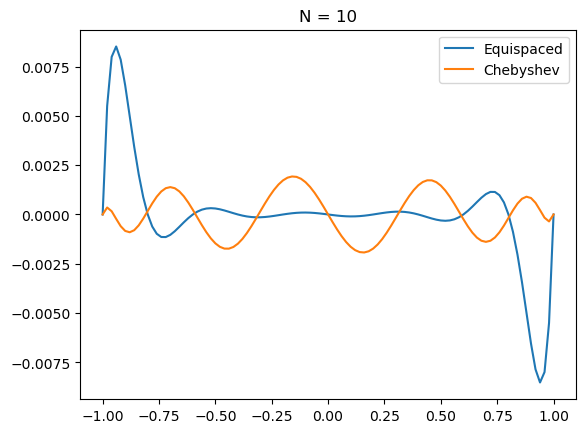

<Figure size 640x480 with 0 Axes>

In [23]:
def w(nodes,x):
    N = len(nodes)
    A = 1
    
    for n in range(N):
        A = A * (x - nodes[n])
        
    return A
# end of w

N = 10
M = 100

nodes_1 = np.linspace(-1,1,N+1)
nodes_2 = cheb_nodes(N)

X = np.linspace(-1,1,M+1)
Y = np.linspace(-1,1,M+1)
Z = np.linspace(-1,1,M+1)

for i in range(M+1):
    Y[i] = w(nodes_1,X[i])
    Z[i] = w(nodes_2,X[i])
# end of for loop in i

plt.plot(X,Y,label = 'Equispaced')
plt.plot(X,Z,label = 'Chebyshev')
plt.legend()
plt.title('N = ' + str(N))
plt.figure()

In [24]:
def f(x):
    return 1 / (1 + 25*x**2)

N = 10
M = 50

x = np.linspace(-1,1,N+1)
y = f(x)
poly = lagrange(x, y)
print(poly)

def plot_and_test(f,M,N,mode):
    X = np.linspace(-1,1,M+1)
    Y = np.linspace(-1,1,M+1) # f values
    # interpolant values
    lagrange_values = np.linspace(-1,1,M+1)
    cheb_values = np.linspace(-1,1,M+1)
    
    equispaced_nodes = np.linspace(-1,1,N+1)

    for i in range(M+1):
        Y[i] = f(X[i])
        lagrange_values[i] = lagrange(equispaced_nodes,f(equispaced_nodes))(X[i])
    # end of for loop to initialize f values for plotting

    start = timer()
    for i in range(M+1):
        if mode == 1: # direct function evaluation
            Z[i] = cheb_approx_1(f,N,X[i])
        elif mode == 2: # SciPy DCT
            Z[i] = cheb_approx_2(f,N,X[i])
        elif mode == 3: # Barycentric formula
            Z[i] = cheb_approx_3(f,N,X[i])
        else:
            raise Exception('Ooff')
            break 
    # end of for loop to initialize interpolant for plotting
    stop = timer()
    time = stop - start
    print('Runtime = ' + str(time))

    plt.plot(X,Y,label = 'f')
    plt.plot(X,Z,label = 'approx, N = ' + str(N))
    plt.legend()
    plt.figure()

    plt.plot(X,abs(Y-Z))
    plt.title('Error for N = ' + str(N))
    max_error = max(abs(Y-Z))
    plt.figure()
    print('Max error = ' + str(max_error))
# end of plot_and_test

        10             9         8             7         6
-220.9 x  + 7.568e-13 x + 494.9 x + 9.979e-13 x - 381.4 x
              5         4             3         2
 - 5.487e-13 x + 123.4 x - 4.267e-14 x - 16.86 x + 1.605e-15 x + 1
